# 3c. Predict bed counts without using patient snapshots

There are situations where we might want to predict bed count distributions without having details of the patients, for example when predicting the number of beds needed:

* for patients yet-to-arrive to the Emergency Department, who will need a bed within a prediction window
* for emergency patients who arrive via other routes than the ED, and become inpatients (such as emergency transfers from other hospitals)
* for elective admissions of patients. Elective patients may be on a 'To Come In' list, but often their encounter for the elective procedure begins at the moment they arrive. In a simple case without making use of any data on TCI lists, we might want to predict based on past patterns of such arrivals between a prediction time (eg 09:30) and the end of a prediction window (eg 8 hours later).  

For these situations, you can use `patientflow` to learn patterns from past data, and use these to predict a bed count distribution at the aggregate level.

In this notebook, I'll use the example of predicting the number of beds needed for patients yet to arrive to the Emergency Department. I'll start by creating a very simple model trained on past data to predict the number of patients. 

I will also include an example of a custom function developed to predict number of patients yet to arrive, who will be admitted within a prediction window assuming ED targets are met. 

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

## Create fake arrival times

I will generate some fake data on patients in an Emergency Department (ED) using the same method as in previous notebooks. 

In [2]:
from patientflow.generate import create_fake_finished_visits
visits_df, _, _ = create_fake_finished_visits('2023-01-01', '2023-04-01', 25)
visits_df.head()

,patient_id,visit_number,arrival_datetime,departure_datetime,is_admitted,age
0,1658,14,2023-01-01 03:31:47,2023-01-01 08:00:47,0,30
1,238,20,2023-01-01 04:25:57,2023-01-01 07:43:57,1,61
2,354,1,2023-01-01 05:21:43,2023-01-01 08:52:43,1,86
3,114,3,2023-01-01 08:01:26,2023-01-01 09:38:26,0,33
4,497,10,2023-01-01 08:20:52,2023-01-01 11:20:52,0,59


For this analysis I only want to make predictions for patienets who are later admitted, so I will delete the non-admitted. 

In [3]:
import pandas as pd

inpatient_arrivals = visits_df[visits_df.is_admitted == 1].rename(columns = {'departure_datetime': 'admitted_to_ward_datetime'}).drop(columns = 'is_admitted')
inpatient_arrivals['arrival_datetime'] = pd.to_datetime(inpatient_arrivals['arrival_datetime'])

I will generate an array of dates covered by the data I've loaded. I'm calling these `snapshot_dates` for consistency.

In [4]:
from datetime import datetime, time, timedelta, date

# Create date range
snapshot_dates = []
start_date = date(2023, 1, 1)
end_date = date(2023, 4, 1)

current_date = start_date
while current_date < end_date:
    snapshot_dates.append(current_date)
    current_date += timedelta(days=1)

print('First ten snapshot dates')
snapshot_dates[0:10]

First ten snapshot dates


[datetime.date(2023, 1, 1),
 datetime.date(2023, 1, 2),
 datetime.date(2023, 1, 3),
 datetime.date(2023, 1, 4),
 datetime.date(2023, 1, 5),
 datetime.date(2023, 1, 6),
 datetime.date(2023, 1, 7),
 datetime.date(2023, 1, 8),
 datetime.date(2023, 1, 9),
 datetime.date(2023, 1, 10)]

## Train a simple Poisson model to predict the patients who are yet-to-arrive

The function below generates counts by snapshot date for the number of patients who arrived after the prediction time and were admitted before the end of the prediction window. 

In [5]:

def count_yet_to_arrive(df, snapshot_dates, prediction_times, prediction_window_hours):
    """
    Count patients who arrived after a prediction time and were admitted to a ward 
    within a specified window.
    """
    # Create an empty list to store results
    results = []
    
    # For each combination of date and time
    for date_val in snapshot_dates:
        for hour, minute in prediction_times:
            # Create the prediction datetime
            prediction_datetime = pd.Timestamp(datetime.combine(date_val, time(hour=hour, minute=minute)))

            # Calculate the end of the prediction window
            prediction_window_end = prediction_datetime + pd.Timedelta(hours=prediction_window_hours)
            
            # Count patients who arrived after prediction time and were admitted within the window
            admitted_within_window = df[
                (df['arrival_datetime'] > prediction_datetime) & 
                (df['admitted_to_ward_datetime'] <= prediction_window_end)
            ]['patient_id'].nunique()
            
            # Store the result
            results.append({
                'snapshot_date': date_val,
                'prediction_time': (hour, minute),
                'count': admitted_within_window
            })
    
    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

As in previous notebooks, I'll apply a temporal split to the data. 

In [6]:
from datetime import date   
from patientflow.prepare import create_temporal_splits

# set the temporal split
start_training_set = date(2023, 1, 1) 
start_validation_set = date(2023, 2, 15) # 6 week training set 
start_test_set = date(2023, 3, 1) # 2 week validation set 
end_test_set = date(2023, 4, 1) # 1 month test set

# create the temporal splits
train_visits, _, _ = create_temporal_splits(
    inpatient_arrivals,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="arrival_datetime", # states which column contains the date to use when making the splits 

)

Split sizes: [313, 109, 206]


After applying the function, the count data is shown below.

In [7]:
prediction_times = [(9, 30)] 

yet_to_arrive_counts = count_yet_to_arrive(train_visits, snapshot_dates, prediction_times, prediction_window_hours=8)
yet_to_arrive_counts.head(10)

,snapshot_date,prediction_time,count
0,2023-01-01,"(9, 30)",1
1,2023-01-02,"(9, 30)",5
2,2023-01-03,"(9, 30)",5
3,2023-01-04,"(9, 30)",2
4,2023-01-05,"(9, 30)",4
5,2023-01-06,"(9, 30)",2
6,2023-01-07,"(9, 30)",2
7,2023-01-08,"(9, 30)",3
8,2023-01-09,"(9, 30)",2
9,2023-01-10,"(9, 30)",4


Here I use the mean daily count as the mean of a Poisson distribution. 

In [8]:
from scipy import stats
poisson_mean = yet_to_arrive_counts['count'].mean()
poisson_model = stats.poisson(poisson_mean)

I use the Poisson model to predict a bed count distribution for the patients yet-to-arrive. 


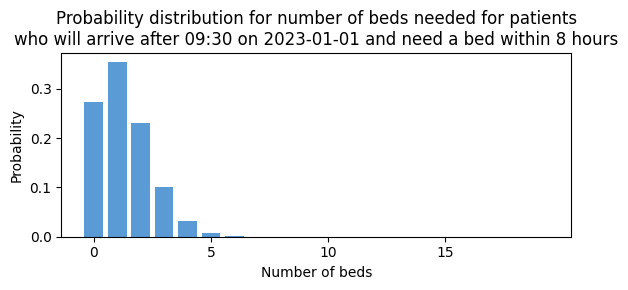

In [9]:
prob_dist_data = [poisson_model.pmf(k) for k in range(20)]

from patientflow.viz.prob_dist_plot import prob_dist_plot
from patientflow.viz.utils import format_prediction_time
title = (
    f'Probability distribution for number of beds needed for patients'
    f'\nwho will arrive after {format_prediction_time((9,30))} on {snapshot_dates[0]} and need a bed within 8 hours'
)
prob_dist_plot(prob_dist_data, title,  
    include_titles=True)

## Train a weighted Poisson model

The model above has learned the rates of arrivals of patients who are later admitted within a prediction window from past data. 

A problem with this approach is that rates are learned from periods of poor performance. Currently, in England Emergency Departments have a target of processing all patients within four hours of their arrival time. However, EDs across the country have not hit targets since the end of the Covid pandemic.

The poor performance is illustrated by the survival curve below, which shows that only 59% of admitted patients left the ED to go to the ward within four hours.

Proportion of patients admitted within 4 hours: 58.76%


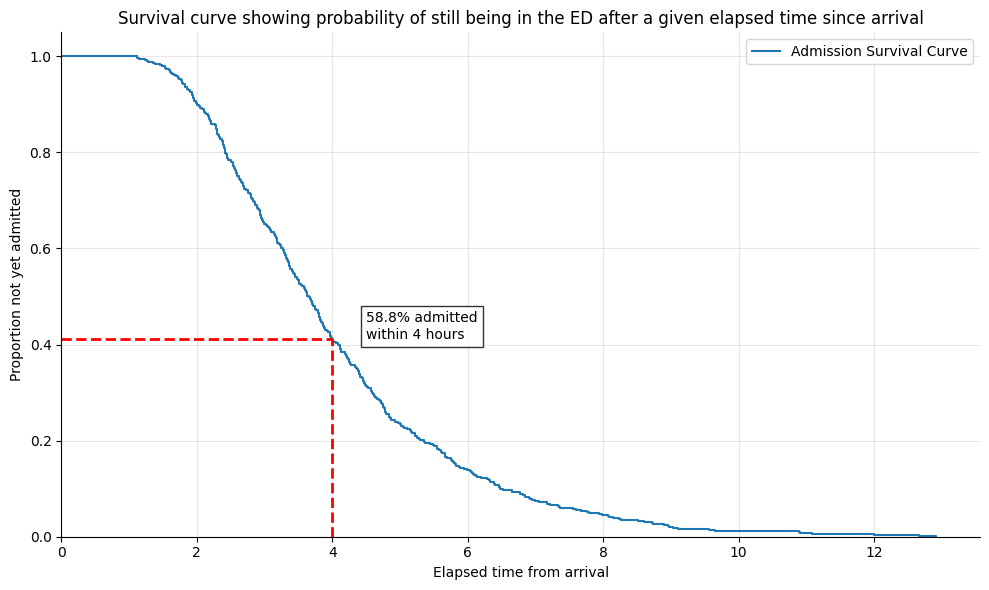

In [10]:
from patientflow.viz.survival_curves import plot_admission_time_survival_curve
title = 'Survival curve showing probability of still being in the ED after a given elapsed time since arrival'
plot_admission_time_survival_curve(inpatient_arrivals, title)

`patientflow` offers a weighted Poisson model, that will calculate each patient's probability of being admitted from their arrival time, if targets are met. Targets are set using the parameters set in config.yaml 

In [11]:
from patientflow.load import load_config_file, set_file_paths, set_project_root
project_root = set_project_root()

_, _, _, config_path = set_file_paths(project_root, data_folder_name = 'data-public', verbose = False)
params = load_config_file(config_path)

x1, y1, x2, y2 = params["x1"], params["y1"], params["x2"], params["y2"]

print(f'The aspiration is that within {str(x1)} hours of arrival, {str(y1*100)}% of patients will have been admitted, and that witin {str(x2)} hours of arrival, {str(y2*100)}% of patients will have been admitted')

Inferred project root: /Users/zellaking/Repos/patientflow
The aspiration is that within 4.0 hours of arrival, 76.0% of patients will have been admitted, and that witin 12.0 hours of arrival, 99.0% of patients will have been admitted


The aspiration can be plotted as an inverted survival curve, as shown below. 

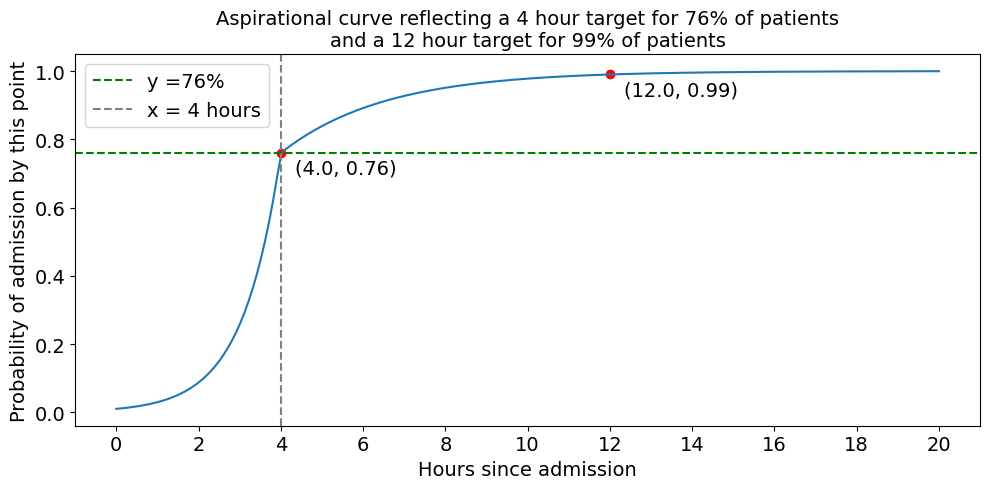

In [12]:
from patientflow.viz.aspirational_curve_plot import plot_curve

figsize = (6,3)

plot_curve(
    title = 'Aspirational curve reflecting a ' + str(int(x1)) + ' hour target for ' + str(int(y1*100)) + \
        '% of patients\nand a '+ str(int(x2)) + ' hour target for ' + str(int(y2*100)) + '% of patients',
    x1 = x1,
    y1 = y1,
    x2 = x2,
    y2 = y2,
    include_titles=True,
    annotate_points=True,
)


Below I demonstrate the use of a Weighted Poisson predictor. 

Its `fit()` method will, for each prediction time:

* filter the dataframe if a filtering criteria is given (more detail below)
* calculate arrival rates for a series of discrete time intervals (where the duration of each time interval is specified as `yta_time_interval` minutes) within a 24 hour period; `yta_time_interval` must divide evenly into a 24 hour period (ie be a factor of 24* 60)
* return the arrival rates for the intervals between the prediction time and the end of the prediction window in a dictionary; if the data is unfiltered it will use a generic key of 'unfiltered'; if the data is filtered, it will use the filters as keys

The `predict()` method will:

* retrieve the arrival rates saved for the prediction window
* for each discrete time interval, using the aspirational curve introduced above, and taking into account the time remaining before end of window, calculate a probability of admission in prediction window 
* weight the arrival rates for each time interval by this probability 
* generate a Poisson distribution for each time interval
* convolute the distributions to return a single distribution for arrivals over all time intervals

In [13]:
from patientflow.predictors.weighted_poisson_predictor import WeightedPoissonPredictor

yta_model =  WeightedPoissonPredictor(verbose=True)
num_days = (start_validation_set - start_training_set).days
if 'arrival_datetime' in train_visits.columns:
    train_visits.set_index('arrival_datetime', inplace=True)

yta_model.fit(train_visits, prediction_window=8*60, yta_time_interval=15, prediction_times=[(9,30)], num_days=num_days)


Calculating time-varying arrival rates for data provided, which spans 45 unique dates
Weighted Poisson Predictor trained for these times: [(9, 30)]
using prediction window of 480 minutes after the time of prediction
and time interval of 15 minutes within the prediction window.
The error value for prediction will be 1e-07
To see the weights saved by this model, used the get_weights() method


WeightedPoissonPredictor(filters={}, verbose=True)

Below we view the results of the fit method for the 09:30 prediction time. 

In [14]:
arrival_rates_by_time_interval = yta_model.weights['unfiltered'][(9,30)]['arrival_rates']
print(
    f'The calculated arrival rates for the first 10 discrete time intervals '
    f'for the 09:30 prediction time are: {[round(v, 3) for v in arrival_rates_by_time_interval[0:10]]}')

The calculated arrival rates for the first 10 discrete time intervals for the 09:30 prediction time are: [0.067, 0.111, 0.111, 0.133, 0.133, 0.133, 0.333, 0.133, 0.178, 0.111]


To use the weighted poisson for prediction, a `prediction_context` argument specifies the required prediction time and filtering. 

In [15]:
from patientflow.viz.prob_dist_plot import prob_dist_plot
from patientflow.viz.utils import format_prediction_time

prediction_context = {
    'unfiltered': {
        'prediction_time': tuple([9,30])
    }
}

weighted_poisson_prediction = yta_model.predict(prediction_context, x1, y1, x2, y2)


The chart below show the results of using this weighted predictor to generate an unfettered distribution for patients yet-to-arrive. The numbers are higher than the equivalent chart above. 

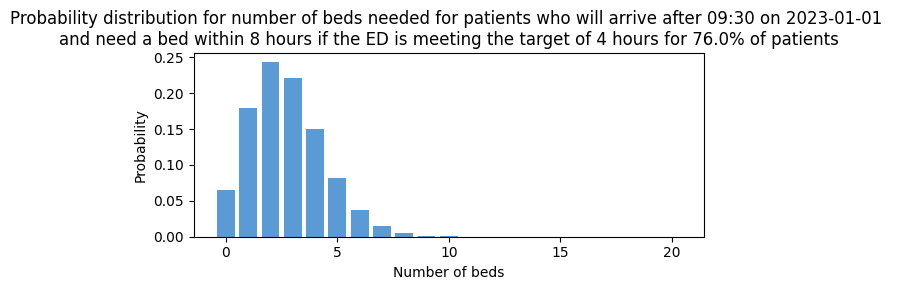

In [16]:
title = (
    f'Probability distribution for number of beds needed for patients '
    f'who will arrive after {format_prediction_time((9,30))} on {snapshot_dates[0]} '
    f'\nand need a bed within 8 hours '
    f'if the ED is meeting the target of {int(x1)} hours for {y1*100}% of patients'
)
prob_dist_plot(weighted_poisson_prediction['unfiltered'], title,  
    include_titles=True,
    truncate_at_beds=20)

## Conclusion

Here I have demonstrated the use of `patientflow` to generate bed counts for groups of patients, without using patient snapshots. 

If you have count data on past visits that approximate to a statistical distribution, preparing a  model to predict a bed count distribution is simple to do with standard libraries like scipy. You don't need `patientflow` functions for that. 

However there might be cases where the historical data don't reflect the desired performance of the ED, as in the example shown here. In that case, the users of your predictions might be more interested in understanding their unfettered demand. `patientflow`  provides functions that enable you to produce such predictions. 